# TP 4 – Time Series in the Real World (Optional)

**Optional lab** (not counted in the final grade)

## Motivation

This lab aims to encourage you to use the whole tools from this course on a real time series. It is not an exam and it is not graded. You are free to:

-   Choose data that you find interesting.
-   Decide how far you want to go: from basic exploratory analysis to more advanced methods from Chapters 3 and 4.
-   If you wish, you can also contrast the analysis with methods from other courses (e.g. classic machine learning or deep learning, Markov models or other tools from stochastic processes and control).
-   Treat this as a small project you can later show (e.g. internship / research interviews).

Focus on **reviewing the course content**, **understanding the data** and **explaining your reasoning**.


## 1. Connection to the Lecture Notes

You are encouraged to apply concepts from different chapters of the lecture notes:

-   **Chapter 2 – Weakly Stationary Processes**

    -   Sample mean, autocovariance, autocorrelation.
    -   Periodogram and spectral density.

-   **Chapter 3 – Linear Models**

    -   Linear filtering by absolutely summable coefficients.
    -   MA(q), AR(p) and ARMA(p, q) processes.
    -   Causal / invertible representations and the idea that many stationary processes can be seen as the output of a
        linear filter applied to white noise.

-   **Chapter 4 – Linear Forecasting**
    -   Linear prediction of a weakly stationary process.
    -   Yule–Walker equations for AR(p) models.
    -   Levinson–Durbin algorithm for solving the Yule–Walker system efficiently.
    -   Innovations process and the innovations algorithm.
    -   Wold decomposition: representing a process as a (possibly infinite) causal MA filter driven by white noise.

You are _not_ required to implement all of these advanced methods.  
However, you are welcome to use them as far as you feel comfortable:

-   For a moderate level, an AR(p) model with Yule–Walker is already enough (recall Lab3).
-   For a more advanced level, you may experiment with ARMA(p, q), Levinson–Durbin, or the innovations algorithm.


## 2. Choice of Data

In this lab you will work with a univariate time series with regular time spacing (e.g. hourly, daily). You can either use one of the provided datasets (A–C) or propose your own dataset (D).

---

### Option A – Electricity Load / Traffic Flow

Examples:

-   Hourly electricity demand for a region or country.
-   Hourly or 15-minute vehicle counts on a road segment.

Questions you might explore:

-   What daily or weekly cycles are visible?
-   Which frequencies dominate the spectrum?
-   Can a simple AR/ARMA model give reasonable short-term forecasts?

---

### Option B – Weather Data (Temperature / Precipitation)

Examples:

-   Daily temperature in a city over several years.
-   Daily precipitation amounts.

Possible questions:

-   What is the seasonal (annual) cycle?
-   Is there a trend over the years?
-   After removing trend and seasonality, does the remainder look weakly stationary?

---

### Option C – Financial Time Series (Returns)

Examples:

-   Daily log-returns of a stock index or exchange rate.

Possible questions:

-   How close are returns to white noise?
-   Is there any short-lag autocorrelation?
-   Do you detect meaningful peaks in the spectrum?

---

### Option D – Your Own Idea

You may propose another time series, for example:

-   Sensor readings, network traffic, web request counts,
-   Audio/music features, EEG/ECG signals, etc.

Before starting the analysis, briefly **describe the dataset** you use (source, variable, resolution, time span).

---

### Predefined Datasets for This Lab

You can work with one of the following three prepared dataset.

**Dataset A – PJM East hourly electricity load (2015)**  
This dataset contains one full year of hourly electricity demand from the PJM East interconnection in the United States.  
The series runs from 1 January 2015 00:00 to 31 December 2015 23:00, for a total of 8760 hourly observations.  
The column `PJME_MW` gives the system load in megawatts.  
This series is well suited to studying daily and weekly seasonality, spectral peaks, and short-term load forecasting with AR/ARMA models.

**Dataset B – Paris daily average temperature (2010–2014)**  
Daily average air temperature for Paris (Europe region) from 1 January 2010 to 31 December 2014 (1826 days).  
The column `AvgTemperature_F` reports the mean temperature.  
It exhibits an annual seasonal cycle and is appropriate for analysing trend and seasonality, checking weak stationarity after suitable transformations, and comparing time-domain and frequency-domain views.

**Dataset C – S&P 500 daily prices and log-returns (2010–2019)**  
Daily observations of the S&P 500 stock index (`^GSPC`) from 5 January 2010 to 31 December 2019.  
The column `Close` is the daily closing price, and `log_return` is the day-to-day log-return computed from the closing prices.  
It allows you to study how close financial returns are to white noise, to examine short-lag autocorrelation, and to contrast the behaviour of financial time series with that of electricity load or temperature data in both the time and frequency domains.


## 3. Data Loading (Example Data and Code)

Feel free to adapt this code to other data and formats.


Loaded series from ParisDailyTemp_2010_2014.csv
Number of observations: 1826
Date
2010-01-01    32.7
2010-01-02    31.7
2010-01-03    29.9
2010-01-04    23.6
2010-01-05    27.0
Name: AvgTemperature_F, dtype: float64


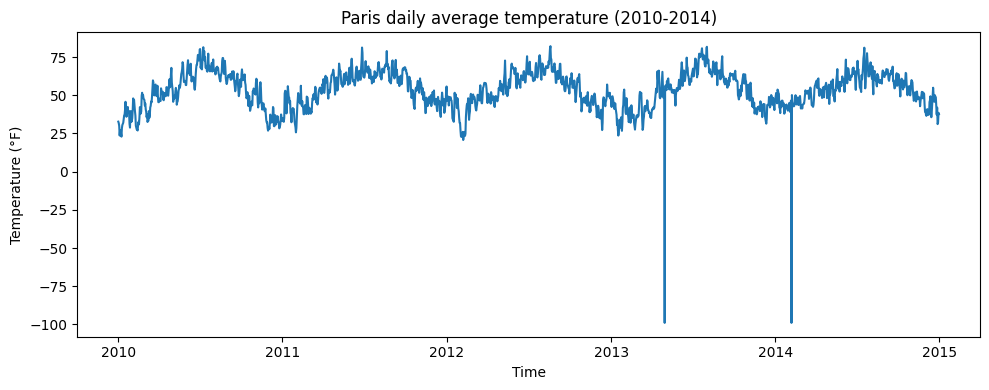

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose which dataset to use:
#   "A" the PJM hourly load (2015)
#   "B" the Paris daily temperature (2010–2014)
#   "C" the S&P 500 daily log-returns (2010–2019)

option = "B"   # change this to "B" or "C" as needed

file_path = ""
date_col = ""
value_col = ""
title = ""
ylabel = ""

if option == "A":
    file_path = "PJME_2015_hourly_subset.csv"
    date_col = "Datetime"
    value_col = "PJME_MW"
    title = "PJM East hourly load (2015)"
    ylabel = "Load (MW)"
elif option == "B":
    file_path = "ParisDailyTemp_2010_2014.csv"
    date_col = "Date"
    value_col = "AvgTemperature_F"
    title = "Paris daily average temperature (2010-2014)"
    ylabel = "Temperature (°F)"
elif option == "C":
    file_path = "SP500_2010_2019_logreturns.csv"
    date_col = "Date"
    value_col = "log_return"   # use "Close" to plot the price
    title = "S&P 500 daily log-returns (2010-2019)"
    ylabel = "Log-return"

# Load the selected dataset and create a time-indexed series
df = pd.read_csv("lab4data/"+file_path, parse_dates=[date_col])
df = df.set_index(date_col).sort_index()

ts = df[value_col]

print(f"Loaded series from {file_path}")
print(f"Number of observations: {len(ts)}")
print(ts.head())

# Quick plot
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title(title)
plt.xlabel("Time")
plt.ylabel(ylabel)
plt.tight_layout()
plt.show()

## 4. Time-Domain Exploration

Try to carry out the following as we did in previous labs:

1. **Visual inspection and data cleaning**

    - Inspect the plotted series.
    - Identify possible outliers, noise, missing values or data errors.
    - Comment on trend, seasonal patterns, or structural breaks.
    - Comment on whether additional preprocessing or transformations are needed.

2. **Stationarity discussion**

    - Discuss whether the series appears weakly stationary.
    - If not, consider simple transformations:
        - Differencing to remove deterministic trends.
        - Seasonal differencing (e.g. lag 24 for daily cycle in hourly data, lag 7 for weekly cycle in daily data).
    - Explain which transformation you chose and why.

3. **Autocovariance and autocorrelation**
    - Compute the empirical autocovariance and autocorrelation functions.
    - Interpret the main features of the ACF: persistence at small lags, periodic patterns, fast/slow decay, etc.


<Figure size 1000x400 with 0 Axes>

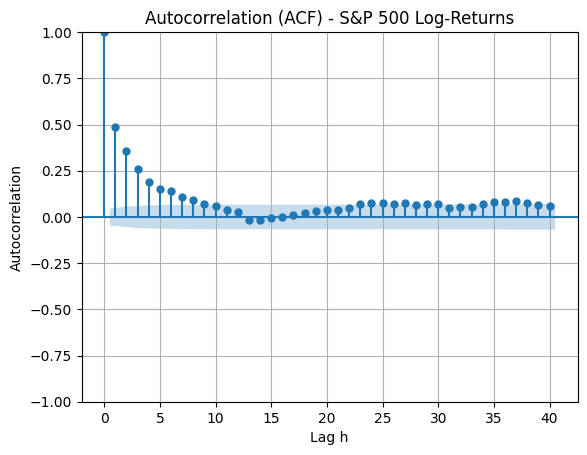

<Figure size 1000x400 with 0 Axes>

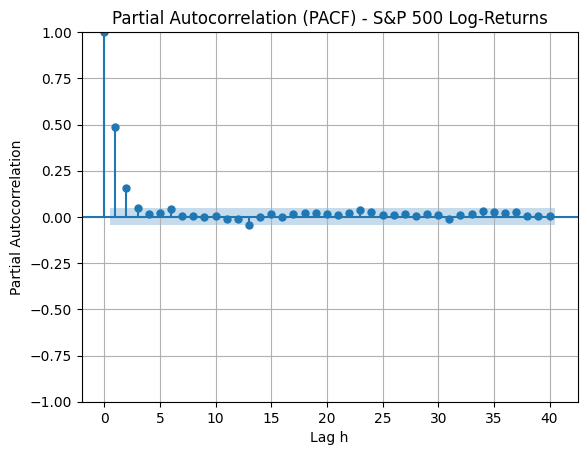

In [21]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend

ts_values = detrend(ts.dropna().values, type="linear") # type: ignore

day_of_year = ts.index.dayofyear # type: ignore

df_temp = pd.DataFrame({'temp': ts, 'day': day_of_year})
seasonal_component = df_temp.groupby('day')['temp'].mean()

if 366 in seasonal_component.index:
    seasonal_component[366] = seasonal_component[365]
    
seasonal_avg = seasonal_component[day_of_year].values

ts = ts - seasonal_avg

ts = pd.Series(ts)
mean = ts.mean()
std = ts.std()
threashold = 4.0

is_outlier = (ts-mean).abs() > threashold * std
ts[is_outlier] = np.nan

ts = ts.interpolate(method="linear").values

plt.figure(figsize=(10, 4))
plot_acf(ts_values, lags=40, title='Autocorrelation (ACF) - S&P 500 Log-Returns')
plt.xlabel('Lag h')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(ts_values, lags=40,
          title='Partial Autocorrelation (PACF) - S&P 500 Log-Returns')
plt.xlabel('Lag h')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

## 5. Spectrum Analysis

Apply the frequency-domain tools from the course:

1. **Periodogram / Spectral density estimate**

    - Compute and plot the periodogram (or a smoothed spectral estimate) of your (approximately) stationary series.
    - Identify any peaks in the spectrum.
    - Relate these peaks to real-world cycles (e.g. daily, weekly, yearly patterns).

2. **Connection with linear filters (Chapter 3)**
    - Recall that a stationary process can often be viewed as the output of a linear filter applied to white noise.
    - Based on the spectrum you observe, discuss informally what kind of filter your data might correspond to:
        - Low-pass (emphasizing slow variations / trend-like behavior)?
        - Band-pass (strong energy at specific frequencies)?
        - High-pass or something more complicated?
    - Explain how this viewpoint connects to MA(q) or ARMA(p, q) models.


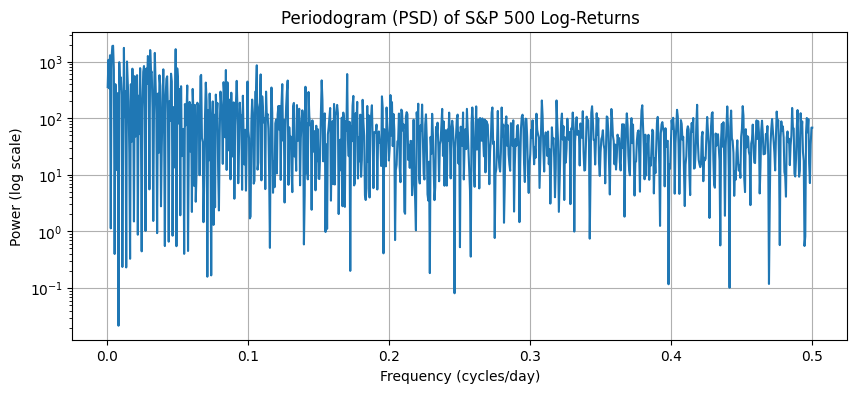

In [25]:
import scipy.signal

f, Pxx = scipy.signal.periodogram(ts_values, window='boxcar', fs=1.0)

plt.figure(figsize=(10, 4))

plt.semilogy(f[1:], Pxx[1:])
plt.title('Periodogram (PSD) of S&P 500 Log-Returns')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power (log scale)')
plt.grid(True)
plt.show()

## 6. Linear Modelling and Prediction (Chapters 3 & 4)

In this part you will model your time series using the linear models from Chapter 3 and the prediction framework
from Chapter 4.

### 6.1 Choosing a Model Class

-   Use your ACF (and if you like, PACF) to decide between:
    -   A pure AR(p) model.
    -   A pure MA(q) model.
    -   An ARMA(p, q) model.

Explain your choice.

### 6.2 Parameter Estimation

Depending on your ambition, you can:

-   Use Yule–Walker equations to estimate the parameters of an AR(p) model.
-   Use code and ideas from Lab 3 as a starting point.
-   Implement the Levinson–Durbin algorithm to solve the Yule–Walker system recursively and obtain both AR
    coefficients and prediction error variances.
-   Extend from AR(p) to ARMA(p, q) by using appropriate numerical routines or libraries.

Clearly state which approach you choose and justify the chosen order(s) p (and q, if relevant).


### 6.3 Linear Forecasting

Using your fitted model conduct:

1. **One-step-ahead prediction**

    - Express the linear predictor of $X_{t+1}$ in terms of past observations, as in Chapter 4.
    - If you use an AR(p) model, this corresponds to a weighted sum of the last p observations.

2. **Multi-step prediction**

    - Discuss (or implement) how to produce forecasts several steps ahead.
    - You may generate a forecast path over a test period and compare it with the observed values.

3. **Train/Test evaluation**

    - Split your time series into a training part and a test part (e.g. last 10% of observations as test set).
    - Fit the model on the training set.
    - Use the model to forecast the test set.
    - Compute simple error measures (MAE, RMSE) and comment on whether the performance is satisfactory for your
      application.

4. **Innovations viewpoint**
    - Relate your predictor to the innovations process introduced in Chapter 4.
    - Optionally, describe how the innovations algorithm could be used to build predictors directly from the
      covariance structure of the process.


Chosen model: AR(3)
Training samples: 1643, Test samples: 183
Estimated AR coefficients (phi): AvgTemperature_F.L1    0.5213
AvgTemperature_F.L2    0.2442
AvgTemperature_F.L3    0.2294
dtype: float64
Estimated noise variance (sigma^2): 56.1055
Test Set RMSE: 4.7014 (°F)


/home/guilherme13c/Documents/TimeSeries1/TP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


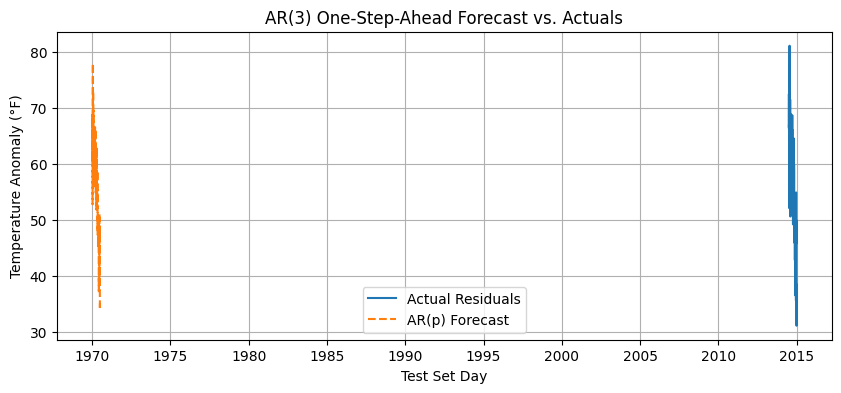

In [29]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse

# --- 6.1 & 6.2: Model Choice and Parameter Estimation ---

# We choose p=3 based on our PACF analysis from Section 4
p = 3
print(f"Chosen model: AR({p})")

# Split data into train (first 90%) and test (last 10%)
split_idx = int(len(ts) * 0.9)
train_data = ts[:split_idx]
test_data = ts[split_idx:]
print(f"Training samples: {len(train_data)}, Test samples: {len(test_data)}")

# Fit an AR(p) model using Yule-Walker equations
# We use statsmodels 'AutoReg' which has a 'yule-walker' method
model = AutoReg(train_data, lags=p, trend='n') # type: ignore # 'n' for no mean/trend (we removed it)
model_fit = model.fit()

# Get the estimated coefficients
phi = model_fit.params
sigma2_est = model_fit.sigma2

print(f"Estimated AR coefficients (phi): {np.round(phi, 4)}")
print(f"Estimated noise variance (sigma^2): {sigma2_est:.4f}")

# --- 6.3: One-Step-Ahead Linear Forecasting ---

# The AR(p) predictor is: X_hat[t] = phi[0]*X[t-1] + ... + phi[p-1]*X[t-p]
predictions = []

# We need the full series (train + test) to get history for the test set
history = list(train_data)

for t in range(len(test_data)):
    # We need the last 'p' observations to make a prediction
    # The 'test_data' starts at index 'split_idx' in the original series
    # So we look at indices (split_idx + t - p) up to (split_idx + t - 1)
    lag_values = ts[split_idx + t - p : split_idx + t]
    
    # Apply the linear predictor equation
    pred = np.dot(phi, lag_values[::-1]) # type: ignore # [phi1, phi2, phi3] dot [X_t-1, X_t-2, X_t-3]
    predictions.append(pred)

# Calculate RMSE on the test set
error = rmse(test_data, predictions)
print(f"Test Set RMSE: {error:.4f} (°F)")
    
    # --- Plot the results ---
plt.figure(figsize=(10, 4))
plt.plot(test_data, label='Actual Residuals') # type: ignore
plt.plot(predictions, label='AR(p) Forecast', linestyle='--')
plt.title(f'AR({p}) One-Step-Ahead Forecast vs. Actuals')
plt.xlabel('Test Set Day')
plt.ylabel('Temperature Anomaly (°F)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Wold Decomposition and Interpretation

1. **Wold decomposition (Chapter 4)**

    - Recall that any purely nondeterministic weakly stationary process can be represented as
      a (possibly infinite-order) causal MA filter applied to a white noise sequence.
    - Discuss how your fitted AR or ARMA model approximates such a representation.

2. **Approximate MA(∞) representation**

    - For an AR(p) model, describe qualitatively how it corresponds to an MA(∞) representation.
    - Connect this idea with the spectral factorization viewpoint: the spectrum of your process can be written in
      terms of the transfer function of a causal filter.

3. **Deterministic vs. stochastic components**
    - From your analysis (trend, seasonality, residuals), discuss what part of your series is "deterministic"
      (predictable by a known pattern) and what part is stochastic (innovation-like noise).
